In [1]:
%pwd

'/home/ubuntu/kaggle/fisheries-monitoring/code'

In [2]:
#Create references to important directories we will use over and over
import os, sys
current_dir = os.getcwd()
CODE_HOME_DIR = current_dir
DATA_HOME_DIR = CODE_HOME_DIR + '/../input/'
print(CODE_HOME_DIR)
print(DATA_HOME_DIR)

/home/ubuntu/kaggle/fisheries-monitoring/code
/home/ubuntu/kaggle/fisheries-monitoring/code/../input/


In [3]:
#Allow relative imports to directories above this folder/
sys.path.insert(1,os.path.join(sys.path[0], '..'))

#import modules
import utils
from utils import *
# from vgg16_ted import vgg16BN
%matplotlib inline

Using TensorFlow backend.
/home/ubuntu/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


#### Setup Paths

In [4]:
%cd $DATA_HOME_DIR

#Set path to sample/ path if desired
path = DATA_HOME_DIR + '/' # + '/sample/'
result_path = path + 'results/'
train_path = path + 'train/'
valid_path = path + 'valid/'
test_path = path + 'test/'
model_path = path + 'models/'

/home/ubuntu/kaggle/fisheries-monitoring/input


In [5]:
batch_size = 64

In [6]:
batches = get_batches(train_path, batch_size=batch_size)
val_batches = get_batches(valid_path, batch_size=batch_size*2, shuffle=False)

(trn_classes, val_classes, trn_labels, val_labels, 
    filenames, val_filenames, test_filenames) = get_classes(path)

Found 3277 images belonging to 8 classes.
Found 500 images belonging to 8 classes.
Found 3277 images belonging to 8 classes.
Found 500 images belonging to 8 classes.
Found 1000 images belonging to 1 classes.


Sometimes it's helpful to have just the filenames, without the path.

In [7]:

# [Linux Environment]
raw_filenames = [f.split('/')[-1] for f in filenames]
raw_val_filenames = [f.split('/')[-1] for f in val_filenames]
raw_test_filenames = [f.split('/')[-1] for f in test_filenames]
"""
# [Windows Environment]
raw_filenames = [f.split('\\')[-1] for f in filenames]
raw_val_filenames = [f.split('\\')[-1] for f in val_filenames]
raw_test_filenames = [f.split('\\')[-1] for f in test_filenames]
"""

"\n# [Windows Environment]\nraw_filenames = [f.split('\\')[-1] for f in filenames]\nraw_val_filenames = [f.split('\\')[-1] for f in val_filenames]\nraw_test_filenames = [f.split('\\')[-1] for f in test_filenames]\n"

In [8]:
len(raw_filenames), len(raw_val_filenames), len(raw_test_filenames)

(3277, 500, 1000)

In [9]:
input_shape = next(batches)[0].shape[1:]
print(input_shape)

(3, 224, 224)


In [10]:
trn_data = load_array(result_path+'trn_data')
val_data = load_array(result_path+'val_data')
test_data = load_array(result_path+'test_data')

## Basic VGG

We start with our usual VGG approach.  We will be using VGG with batch normalization.  We explained how to add batch normalization to VGG in the [imagenet_batchnorm notebook](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/imagenet_batchnorm.ipynb).  VGG with batch normalization is implemented in [vgg_bn.py](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/vgg16bn.py), and there is a version of ``vgg_ft`` (our fine tuning function) with batch norm called ``vgg_ft_bn`` in [utils.py](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/utils.py).

### Initial model

First we create a simple fine-tuned VGG model to be our starting point.

In [69]:
from vgg16bn_ted import Vgg16BN
model = vgg_ft_bn(8)

In [16]:
model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
model.fit(trn_data, trn_labels, epochs=2, verbose=2, batch_size=batch_size,
         validation_data=(val_data, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/2
 - 60s - loss: 2.8793 - acc: 0.4721 - val_loss: 1.7777 - val_acc: 0.5880
Epoch 2/2
 - 41s - loss: 1.6172 - acc: 0.6393 - val_loss: 0.7486 - val_acc: 0.7580


In [18]:
model.fit(trn_data, trn_labels, epochs=8, verbose=2, batch_size=batch_size,
         validation_data=(val_data, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/8
 - 41s - loss: 1.3832 - acc: 0.6906 - val_loss: 0.6206 - val_acc: 0.8060
Epoch 2/8
 - 41s - loss: 1.1034 - acc: 0.7473 - val_loss: 0.4756 - val_acc: 0.8620
Epoch 3/8
 - 41s - loss: 0.9473 - acc: 0.7760 - val_loss: 0.4972 - val_acc: 0.8520
Epoch 4/8
 - 41s - loss: 0.8619 - acc: 0.7879 - val_loss: 0.4649 - val_acc: 0.8740
Epoch 5/8
 - 41s - loss: 0.8175 - acc: 0.7943 - val_loss: 0.4013 - val_acc: 0.8900
Epoch 6/8
 - 41s - loss: 0.7713 - acc: 0.8016 - val_loss: 0.4133 - val_acc: 0.9120
Epoch 7/8
 - 41s - loss: 0.7706 - acc: 0.8096 - val_loss: 0.4233 - val_acc: 0.9040
Epoch 8/8
 - 41s - loss: 0.7125 - acc: 0.8004 - val_loss: 0.4251 - val_acc: 0.8920


In [19]:
model.save_weights(model_path+'ft1.h5')

### Precompute convolutional output

We pre-compute the output of the last convolution layer of VGG, since we're unlikely to need to fine-tune those layers. (All following analysis will be done on just the pre-computed convolutional features.)

In [70]:
model.load_weights(model_path+'ft1.h5')

In [71]:
conv_layers, fc_layers = split_at(model, Conv2D)

In [72]:
conv_model = Sequential(conv_layers)

In [73]:
conv_features = load_array(result_path+'conv_features.dat')
conv_val_features = load_array(result_path+'conv_val_features.dat')
conv_test_features = load_array(result_path+'conv_test_features.dat')

In [74]:
conv_val_features.shape

(500, 512, 14, 14)

### Train model

We can now create our first baseline model - a simple 3-layer FC net.

In [133]:
def get_bn_model(p):
    model = Sequential([
        MaxPooling2D(input_shape=conv_model.layers[-1].output_shape[1:]),
        BatchNormalization(axis=1),
        Dropout(p/4),
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(p/2),
        Dense(8, activation='softmax')
    ])
    model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [134]:
bn_model = get_bn_model(0.)

In [135]:
bn_model.fit(conv_features, trn_labels, epochs=4, verbose=2,
            validation_data=(conv_val_features, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/4
 - 7s - loss: 0.6633 - acc: 0.8309 - val_loss: 0.3247 - val_acc: 0.9420
Epoch 2/4
 - 5s - loss: 0.1048 - acc: 0.9765 - val_loss: 0.1664 - val_acc: 0.9660
Epoch 3/4
 - 5s - loss: 0.0275 - acc: 0.9924 - val_loss: 0.1894 - val_acc: 0.9700
Epoch 4/4
 - 5s - loss: 0.0309 - acc: 0.9936 - val_loss: 0.1713 - val_acc: 0.9700


In [33]:
bn_model.lr = 1e-4

In [34]:
bn_model.fit(conv_features, trn_labels, epochs=6, verbose=2,
            validation_data=(conv_val_features, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/6
 - 5s - loss: 0.0388 - acc: 0.9899 - val_loss: 0.2029 - val_acc: 0.9720
Epoch 2/6
 - 5s - loss: 0.0236 - acc: 0.9951 - val_loss: 0.1763 - val_acc: 0.9760
Epoch 3/6
 - 5s - loss: 0.0143 - acc: 0.9969 - val_loss: 0.2179 - val_acc: 0.9580
Epoch 4/6
 - 5s - loss: 0.0339 - acc: 0.9896 - val_loss: 0.1698 - val_acc: 0.9720
Epoch 5/6
 - 5s - loss: 0.0083 - acc: 0.9976 - val_loss: 0.1898 - val_acc: 0.9660
Epoch 6/6
 - 5s - loss: 0.0076 - acc: 0.9982 - val_loss: 0.1864 - val_acc: 0.9740


In [35]:
bn_model.save_weights(model_path+'conv_512_1.h5')

In [136]:
bn_model.evaluate(conv_val_features, val_labels)


500/500 [==============================] - 0s 706us/step


[0.17129597639292479, 0.96999999952316285]

In [137]:
bn_model.load_weights(model_path+'conv_512_1.h5')

## Multi-input

The images are of different sizes, which are likely to represent the boat they came from (since different boats will use different cameras). Perhaps this creates some data leakage that we can take advantage of to get a better Kaggle leaderboard position? To find out, first we create arrays of the file sizes for each image:

In [93]:
import PIL

In [94]:
trn_sizes = [PIL.Image.open(train_path+f).size for f in filenames]
id2sizes = list(set(trn_sizes))
sizes2id = {o:i for i, o in enumerate(id2sizes)}

In [95]:
print(id2sizes), print(sizes2id)

[(1280, 974), (1280, 750), (1244, 700), (1732, 974), (1334, 750), (1192, 670), (1280, 720), (1276, 718), (1518, 854), (1280, 924)]
{(1280, 974): 0, (1280, 750): 1, (1244, 700): 2, (1732, 974): 3, (1334, 750): 4, (1192, 670): 5, (1280, 720): 6, (1276, 718): 7, (1518, 854): 8, (1280, 924): 9}


(None, None)

In [96]:
from collections import Counter
Counter(trn_sizes)

Counter({(1192, 670): 179,
         (1244, 700): 20,
         (1276, 718): 194,
         (1280, 720): 1874,
         (1280, 750): 525,
         (1280, 924): 49,
         (1280, 974): 348,
         (1334, 750): 26,
         (1518, 854): 31,
         (1732, 974): 31})

Then we one-hot encode them (since we want to treat them as categorical) and normalize the data.

In [97]:
#trn_sizes_oh = onehot([sizes2id[s] for s in trn_sizes])
trn_sizes_oh = to_categorical([sizes2id[s] for s in trn_sizes], len(sizes2id)) # same

In [98]:
val_sizes = [PIL.Image.open(valid_path+f).size for f in val_filenames]

In [99]:
val_sizes_oh = to_categorical([sizes2id[s] for s in val_sizes], len(sizes2id))

In [100]:
trn_sizes_oh_norm = (trn_sizes_oh - trn_sizes_oh.mean(axis=0) /  trn_sizes_oh.std(axis=0))

In [101]:
val_sizes_oh_norm = (val_sizes_oh - trn_sizes_oh.mean(axis=0) /  trn_sizes_oh.std(axis=0))

In [102]:
trn_sizes_oh_norm.shape, val_sizes_oh_norm.shape

((3277, 10), (500, 10))

In [104]:
test_sizes = [PIL.Image.open(test_path+f).size for f in test_filenames]

In [105]:
test_sizes_oh = to_categorical([sizes2id[s] for s in test_sizes], len(sizes2id))

In [106]:
test_sizes_oh_norm = (test_sizes_oh - test_sizes_oh.mean(axis=0) /  test_sizes_oh.std(axis=0))

In [107]:
test_sizes_oh_norm.shape

(1000, 10)

To use this additional "meta-data", we create a model with multiple input layers - `sz_inp` will be our input for the size information.

In [110]:
from keras.layers import Concatenate

In [111]:
l2rate = 0
p = 0.6

In [112]:
inp = Input(shape=conv_model.layers[-1].output_shape[1:])
size_inp = Input(shape=(len(sizes2id),))
bn_size_inp = BatchNormalization()(size_inp)

x = MaxPooling2D()(inp)
x = BatchNormalization(axis=1)(x)
x = Dropout(p/4)(x)
x = Flatten()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(l2rate))(x)
x = BatchNormalization()(x)
x = Dropout(p)(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(l2rate))(x)
x = BatchNormalization()(x)
x = Dropout(p/2)(x)
x = Concatenate()([x, bn_size_inp])
x = Dense(8, activation='softmax')(x)

When we compile the model, we have to specify all the input layers in an array.

In [113]:
model = Model([inp, size_inp], x)
model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

And when we train the model, we have to provide all the input layers' data in an array.

In [114]:
model.fit([conv_features, trn_sizes_oh_norm], trn_labels, epochs=2, verbose=2,
          validation_data=([conv_val_features, val_sizes_oh_norm], val_labels), batch_size=batch_size)

Train on 3277 samples, validate on 500 samples
Epoch 1/2
 - 10s - loss: 1.0709 - acc: 0.6750 - val_loss: 0.6908 - val_acc: 0.8880
Epoch 2/2
 - 4s - loss: 0.2913 - acc: 0.9207 - val_loss: 0.2972 - val_acc: 0.9440


In [115]:
model.lr = 1e-4

In [116]:
model.fit([conv_features, trn_sizes_oh_norm], trn_labels, epochs=8, verbose=2,
          validation_data=([conv_val_features, val_sizes_oh_norm], val_labels), batch_size=batch_size)

Train on 3277 samples, validate on 500 samples
Epoch 1/8
 - 4s - loss: 0.1382 - acc: 0.9619 - val_loss: 0.1925 - val_acc: 0.9600
Epoch 2/8
 - 4s - loss: 0.0724 - acc: 0.9786 - val_loss: 0.1806 - val_acc: 0.9680
Epoch 3/8
 - 4s - loss: 0.0828 - acc: 0.9759 - val_loss: 0.2030 - val_acc: 0.9720
Epoch 4/8
 - 4s - loss: 0.0512 - acc: 0.9866 - val_loss: 0.1963 - val_acc: 0.9680
Epoch 5/8
 - 4s - loss: 0.0334 - acc: 0.9921 - val_loss: 0.1615 - val_acc: 0.9720
Epoch 6/8
 - 4s - loss: 0.0451 - acc: 0.9881 - val_loss: 0.1884 - val_acc: 0.9640
Epoch 7/8
 - 4s - loss: 0.0404 - acc: 0.9881 - val_loss: 0.2077 - val_acc: 0.9640
Epoch 8/8
 - 4s - loss: 0.0412 - acc: 0.9881 - val_loss: 0.1915 - val_acc: 0.9680


The model did not show an improvement by using the leakage, other than in the early epochs. This is most likely because the information about what boat the picture came from is readily identified from the image itself, so the meta-data turned out not to add any additional information.

## Bounding boxes & multi output

### Import / view bounding boxes

A kaggle user has created bounding box annotations for each fish in each training set image. You can download them [from here](https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring/forums/t/25902/complete-bounding-box-annotation). We will see if we can utilize this additional information. First, we'll load in the data, and keep just the largest bounding box for each image.

In [117]:
import ujson as json

In [118]:
annot_path = os.path.join(path, 'annos')

def get_annotations():
    annot_urls = {
        '5458/bet_labels.json': 'bd20591439b650f44b36b72a98d3ce27',
        '5459/shark_labels.json': '94b1b3110ca58ff4788fb659eda7da90',
        '5460/dol_labels.json': '91a25d29a29b7e8b8d7a8770355993de',
        '5461/yft_labels.json': '9ef63caad8f076457d48a21986d81ddc',
        '5462/alb_labels.json': '731c74d347748b5272042f0661dad37c',
        '5463/lag_labels.json': '92d75d9218c3333ac31d74125f2b380a'
    }
    cache_subdir = os.path.abspath(os.path.join(path, 'annos'))
    url_prefix = 'https://kaggle2.blob.core.windows.net/forum-message-attachments/147157/'

    if not os.path.exists(cache_subdir): os.makedirs(cache_subdir)
        
    for url_suffix, md5_hash in annot_urls.items():
        fname = url_suffix.rsplit('/', 1)[-1]
        get_file(fname, url_prefix+url_suffix, cache_subdir=cache_subdir, md5_hash=md5_hash)

In [119]:
get_annotations()

In [120]:
anno_classes = ['alb', 'bet', 'dol', 'lag', 'other', 'shark', 'yft']

In [121]:
def get_bb_annotations():
    bb_json = {}
    for c in anno_classes:
        if c == 'other': continue  # no annotation file for "other" class
        with open("annos/{}_labels.json".format(c), 'r', encoding='utf8') as f:
            j = json.load(f)
            for l in j:
                if l['annotations']:
                    fname = l['filename'].rsplit('/',-1)[-1]
                    biggest_box_anno = sorted(l['annotations'], key=lambda x: x['height']*x['width'])[-1]
                    bb_json[fname] = biggest_box_anno
    return bb_json

In [122]:
bb_json = get_bb_annotations()

In [123]:
bb_json['img_04908.jpg']

{'class': 'rect',
 'height': 246.75000000000074,
 'width': 432.8700000000013,
 'x': 465.3000000000014,
 'y': 496.32000000000147}

In [124]:
file2idx = {o:i for i,o in enumerate(raw_filenames)}
val_file2idx = {o:i for i,o in enumerate(raw_val_filenames)}

For any images that have no annotations, we'll create an empty bounding box.

In [125]:
empty_box = { 'height': 0., 'width': 0., 'x': 0., 'y': 0.}

In [126]:
for f in raw_filenames:
    if not f in bb_json: bb_json[f]= empty_box   
for f in raw_val_filenames:
    if not f in bb_json: bb_json[f]= empty_box   

Finally, we convert the dictionary into an array, and convert the coordinates to our resized 224x224 images.

In [127]:
def convert_bb(bb, size):
    bb_params = ['height', 'width', 'x', 'y']
    bb = [bb[p] for p in bb_params]
    conv_x = (224. / size[0])
    conv_y = (224. / size[1])
    bb[0] = bb[0] * conv_y
    bb[1] = bb[1] * conv_x
    bb[2] = max(bb[2]*conv_x, 0)
    bb[3] = max(bb[3]*conv_y, 0)
    return bb

In [128]:
trn_bbox = np.stack([convert_bb(bb_json[f], s) for f, s in zip(raw_filenames, trn_sizes)]).astype(np.float32)
val_bbox = np.stack([convert_bb(bb_json[f], s) for f, s in zip(raw_val_filenames, val_sizes)]).astype(np.float32)

In [129]:
trn_bbox.shape, val_bbox.shape

((3277, 4), (500, 4))

Now we can check our work by drawing one of the annotations.

In [130]:
def create_rect(bb, color='red'):
    return plt.Rectangle((bb[2], bb[3]), bb[1], bb[0], color=color, fill=False, lw=3)

In [131]:
def show_bb(i):
    bb = val_bbox[i]
    plt.figure(1)
    plt.imshow(np.rollaxis(val_data[i], 0, 3).astype(np.uint8))
    plt.gca().add_patch(create_rect(bb))

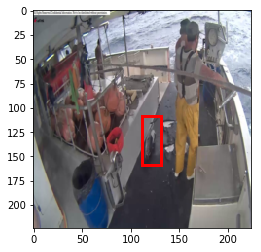

In [132]:
show_bb(4)

### Create & train model

Since we're not allowed (by the kaggle rules) to manually annotate the test set, we'll need to create a model that predicts the locations of the bounding box on each image. To do so, we create a model with multiple outputs: it will predict both the type of fish (the 'class'), and the 4 bounding box coordinates. We prefer this approach to only predicting the bounding box coordinates, since we hope that giving the model more context about what it's looking for will help it with both tasks.

In [75]:
l2rate = 0
p = 0.6

In [76]:
inp = Input(shape=conv_model.layers[-1].output_shape[1:])
x = MaxPooling2D()(inp)
x = BatchNormalization(axis=1)(x)
x = Dropout(p/4)(x)
x = Flatten()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(l2rate))(x)
x = BatchNormalization()(x)
x = Dropout(p)(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(l2rate))(x)
x = BatchNormalization()(x)
x = Dropout(p/2)(x)
x_bb = Dense(4, activation='relu', name='bb')(x)
x_class = Dense(8, activation='softmax', name='class')(x)

Since we have multiple outputs, we need to provide them to the model constructor in an array, and we also need to say what loss function to use for each. We also weight the bounding box loss function down by 1000x since the scale of the cross-entropy loss and the MSE is very different.

In [77]:
model = Model([inp], [x_bb, x_class])
model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'], loss_weights=[.001, 1.])

In [ ]:
print(trn_bbox.shape)
print(trn_bbox.mean(axis=0).shape)
print(trn_bbox.std(axis=0).shape)
print(trn_bbox.mean(axis=0))
print(trn_bbox.std(axis=0))

In [50]:
trn_bbox_norm = (trn_bbox-trn_bbox.mean(axis=0)) / trn_bbox.std(axis=0)
val_bbox_norm = (val_bbox-trn_bbox.mean(axis=0)) / trn_bbox.std(axis=0)

In [51]:
model.fit(conv_features, [trn_bbox_norm, trn_labels], epochs=2, verbose=2,
         validation_data=(conv_val_features, [val_bbox_norm, val_labels]), batch_size=batch_size)

Train on 3277 samples, validate on 500 samples
Epoch 1/2
 - 11s - loss: 1.1566 - bb_loss: -1.4731e+00 - class_loss: 1.1581 - bb_acc: 0.2557 - class_acc: 0.6674 - val_loss: 0.8099 - val_bb_loss: -7.5405e+00 - val_class_loss: 0.8174 - val_bb_acc: 0.3360 - val_class_acc: 0.8580
Epoch 2/2
 - 4s - loss: 0.2906 - bb_loss: -4.0238e+00 - class_loss: 0.2946 - bb_acc: 0.3262 - class_acc: 0.9097 - val_loss: 0.2790 - val_bb_loss: -8.7161e+00 - val_class_loss: 0.2877 - val_bb_acc: 0.4220 - val_class_acc: 0.9420


In [52]:
model.optimizer.lr = 1e-5

In [195]:
model.fit(conv_features, [trn_bbox_norm, trn_labels], epochs=2, verbose=2,
         validation_data=(conv_val_features, [val_bbox_norm, val_labels]), batch_size=batch_size)

Train on 3277 samples, validate on 500 samples
Epoch 1/2
 - 4s - loss: 0.1293 - bb_loss: -4.1111e+00 - class_loss: 0.1334 - bb_acc: 0.3302 - class_acc: 0.9631 - val_loss: 0.2008 - val_bb_loss: -8.8507e+00 - val_class_loss: 0.2096 - val_bb_acc: 0.3240 - val_class_acc: 0.9620
Epoch 2/2
 - 4s - loss: 0.0773 - bb_loss: -4.7220e+00 - class_loss: 0.0820 - bb_acc: 0.3720 - class_acc: 0.9762 - val_loss: 0.1919 - val_bb_loss: -7.2586e+00 - val_class_loss: 0.1991 - val_bb_acc: 0.3700 - val_class_acc: 0.9620


Excitingly, it turned out that the classification model is much improved by giving it this additional task. Let's see how well the bounding box model did by taking a look at its output.

In [224]:
pred = model.predict(conv_val_features[0:50])

In [225]:
def show_bb_pred(i):
    bb = val_bbox[i]
    print(bb)
    bb_pred = pred[0][i] * trn_bbox.std(axis=0) + trn_bbox.mean(axis=0)
    print(bb_pred)
    plt.figure(figsize=(6,6))
    plt.imshow(np.rollaxis(val_data[i], 0, 3).astype(np.uint8))
    ax=plt.gca()
    ax.add_patch(create_rect(bb_pred, 'yellow'))
    ax.add_patch(create_rect(bb))

[  49.13066483   56.75249863  136.45274353   45.18266678]
[ 37.5188446   32.11601639  67.1262207   73.12908936]


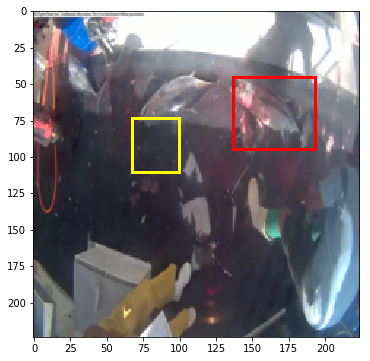

In [226]:
show_bb_pred(32)

In [227]:
res = model.evaluate(conv_val_features, [val_bbox, val_labels])
print(model.metrics_names)
print(res)


500/500 [==============================] - 0s 711us/step
['loss', 'bb_loss', 'class_loss', 'bb_acc', 'class_acc']
[1.3043933732509614, 1105.266869140625, 0.19912644585967063, 0.44800000047683713, 0.96199999904632572]


In [229]:
model.save_weights(model_path+'bn_anno.h5')

In [79]:
model.load_weights(model_path+'/bn_anno.h5')

## Larger size

### Set up data

Let's see if we get better results if we use larger images. We'll use 640x360, since it's the same shape as the most common size we saw earlier (1280x720), without being too big.

In [15]:
trn_data_resize = load_array(result_path+'trn_640.dat')
val_data_resize = load_array(result_path+'val_640.dat')

In [18]:
test_data_resize = load_array(result_path+'test_640.dat')

The image shows that things are much clearer at this size.

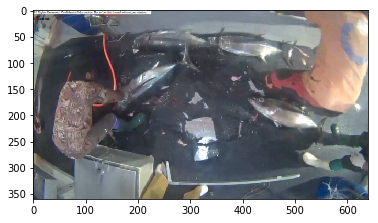

In [19]:
plt.imshow(np.rollaxis(trn_data_resize[0], 0, 3).astype(np.uint8))

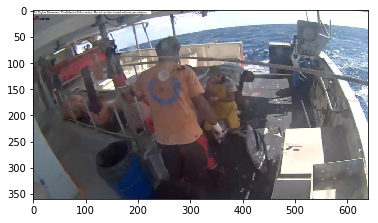

In [20]:
plt.imshow(np.rollaxis(test_data_resize[50], 0, 3).astype(np.uint8))

We can now create our VGG model - we'll need to tell it we're not using the normal 224x224 images, which also means it won't include the fully connected layers (since they don't make sense for non-default sizes). We will also remove the last max pooling layer, since we don't want to throw away information yet.

In [21]:
vgg640 = Vgg16BN(size=(360, 640), include_top=False)

In [22]:
vgg640.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3, 360, 640)       0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 3, 360, 640)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 360, 640)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 360, 640)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 180, 320)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 180, 320)     73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 180, 320)     147584    
__________

In [23]:
vgg640.model.layers.pop()

In [24]:
vgg640.model = Model(vgg640.model.input, vgg640.model.layers[-1].output)

In [25]:
vgg640.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3, 360, 640)       0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 3, 360, 640)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 360, 640)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 360, 640)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 180, 320)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 180, 320)     73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 180, 320)     147584    
__________

In [26]:
vgg640.model.compile(Adam(), 'categorical_crossentropy', metrics=['accuracy'])

In [27]:
vgg640.model.input_shape, vgg640.model.output_shape

((None, 3, 360, 640), (None, 512, 22, 40))

In [28]:
conv_features_640 = load_array(result_path+"conv_features_640.dat")
conv_val_features_640 = load_array(result_path+"conv_val_features_640.dat")
conv_test_features_640 = load_array(result_path+"conv_test_features_640.dat")

In [29]:
conv_features_640.shape

(3277, 512, 22, 40)

### Fully convolutional net (FCN)

Since we're using a larger input, the output of the final convolutional layer is also larger. So we probably don't want to put a dense layer there - that would be a *lot* of parameters! Instead, let's use a fully convolutional net (FCN); this also has the benefit that they tend to generalize well, and also seems like a good fit for our problem (since the fish are a small part of the image).

In [30]:
conv_layers,_ = split_at(vgg640.model, Conv2D)

In [31]:
conv_layers[-1].output_shape

(None, 512, 22, 40)

I'm not using any dropout, since I found I got better results without it.

In [32]:
nf=128; p=0.

In [33]:
from keras.layers import GlobalAveragePooling2D, Activation

In [34]:
def get_lrg_layers():
    return [
        BatchNormalization(axis=1, input_shape=conv_layers[-1].output_shape[1:]),
        Conv2D(nf, (3,3), activation='relu', padding='same'),
        MaxPooling2D(),
        BatchNormalization(axis=1),
        Conv2D(nf, (3,3), activation='relu', padding='same'),
        MaxPooling2D(),
        BatchNormalization(axis=1),
        Conv2D(nf, (3,3), activation='relu', padding='same'),
        MaxPooling2D((1,2)),
        #MaxPooling2D(),
        BatchNormalization(axis=1),
        Conv2D(8, (3,3), activation='relu', padding='same'),
        Dropout(p),
        GlobalAveragePooling2D(),
        Activation('softmax')
    ]

In [35]:
lrg_model = Sequential(get_lrg_layers())

In [36]:
lrg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 512, 22, 40)       2048      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 128, 22, 40)       589952    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 128, 11, 20)       0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 11, 20)       512       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 128, 11, 20)       147584    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 128, 5, 10)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 128, 5, 10)        512       
__________

In [203]:
lrg_model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [204]:
lrg_model.fit(conv_features_640, trn_labels, epochs=2, verbose=2,
             validation_data=(conv_val_features_640, val_labels), batch_size=batch_size)

Train on 3277 samples, validate on 500 samples
Epoch 1/2
 - 16s - loss: 0.7669 - acc: 0.7614 - val_loss: 4.2835 - val_acc: 0.3000
Epoch 2/2
 - 12s - loss: 0.1690 - acc: 0.9542 - val_loss: 0.7684 - val_acc: 0.7600


In [205]:
lrg_model.lr = 1e-6

In [206]:
lrg_model.fit(conv_features_640, trn_labels, epochs=6, verbose=2,
             validation_data=(conv_val_features_640, val_labels), batch_size=batch_size)

Train on 3277 samples, validate on 500 samples
Epoch 1/6
 - 12s - loss: 0.0604 - acc: 0.9878 - val_loss: 0.2175 - val_acc: 0.9480
Epoch 2/6
 - 12s - loss: 0.0209 - acc: 0.9957 - val_loss: 0.2767 - val_acc: 0.9480
Epoch 3/6
 - 12s - loss: 0.0234 - acc: 0.9930 - val_loss: 0.1946 - val_acc: 0.9520
Epoch 4/6
 - 12s - loss: 0.0097 - acc: 0.9985 - val_loss: 0.1586 - val_acc: 0.9640
Epoch 5/6
 - 12s - loss: 0.0108 - acc: 0.9969 - val_loss: 0.1763 - val_acc: 0.9620
Epoch 6/6
 - 12s - loss: 0.0574 - acc: 0.9854 - val_loss: 0.3063 - val_acc: 0.9420


When I submitted the results of this model to Kaggle, I got the best single model results of any shown here (ranked 22nd on the leaderboard as at Dec-6-2016.)

In [207]:
lrg_model.save_weights(model_path+'lrg_nmp.h5')

In [37]:
lrg_model.load_weights(model_path+'lrg_nmp.h5')

In [209]:
lrg_model.evaluate(conv_val_features_640, val_labels)


500/500 [==============================] - 2s 4ms/step


[0.30630294142704223, 0.94199999999999995]

Another benefit of this kind of model is that the last convolutional layer has to learn to classify each part of the image (since there's only an average pooling layer after). Let's create a function that grabs the output of this layer (which is the 4th-last layer of our model).

In [183]:
l = lrg_model.layers
conv_fn = K.function([l[0].input, K.learning_phase()], [l[-4].output])

In [184]:
l[-4].output

<tf.Tensor 'conv2d_62/Relu:0' shape=(?, 8, 5, 5) dtype=float32>

In [185]:
import scipy

In [186]:
def get_cm(inp, label):
    #conv = conv_fn([inp,0])[0, label]
    conv = conv_fn([inp,0])[0][0, label]
    return scipy.misc.imresize(conv, (360, 640), interp='nearest')

We have to add an extra dimension to our input since the CNN expects a 'batch' (even if it's just a batch of one).

In [293]:
img_num = 190

In [294]:
inp = np.expand_dims(conv_val_features_640[img_num], 0)
np.round(lrg_model.predict(inp),2)

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]], dtype=float32)

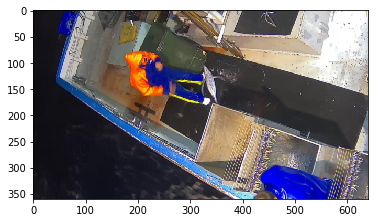

In [295]:
plt.imshow(to_plot(val_data_resize[img_num]))

In [296]:
test_img = conv_fn([inp,0])[0][0, 0]
print(test_img.shape)
scipy.misc.imresize(test_img, (360, 640), interp='nearest').shape

(5, 5)


(360, 640)

In [297]:
cm = get_cm(inp, 0)

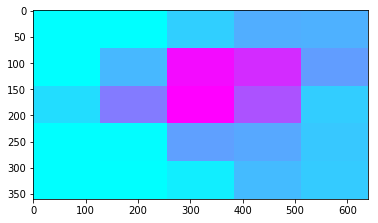

In [298]:
plt.imshow(cm, cmap="cool")

### All convolutional net heatmap

To create a higher resolution heatmap, we'll remove all the max pooling layers, and repeat the previous steps.

In [299]:
def get_lrg_layers_hm():
    return [
        BatchNormalization(axis=1, input_shape=conv_layers[-1].output_shape[1:]),
        Conv2D(nf, (3,3), activation='relu', padding='same'),
        BatchNormalization(axis=1),
        Conv2D(nf, (3,3), activation='relu', padding='same'),
        BatchNormalization(axis=1),
        Conv2D(nf, (3,3), activation='relu', padding='same'),
        BatchNormalization(axis=1),
        Conv2D(8, (3,3), activation='relu', padding='same'),
        GlobalAveragePooling2D(),
        Activation('softmax')
    ]

In [300]:
lrg_model = Sequential(get_lrg_layers_hm())

In [301]:
lrg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_46 (Batc (None, 512, 22, 40)       2048      
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 128, 22, 40)       589952    
_________________________________________________________________
batch_normalization_47 (Batc (None, 128, 22, 40)       512       
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 128, 22, 40)       147584    
_________________________________________________________________
batch_normalization_48 (Batc (None, 128, 22, 40)       512       
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 128, 22, 40)       147584    
_________________________________________________________________
batch_normalization_49 (Batc (None, 128, 22, 40)       512       
__________

In [302]:
lrg_model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [305]:
lrg_model.fit(conv_features_640, trn_labels, epochs=4, verbose=2,
             validation_data=(conv_val_features_640, val_labels), batch_size=batch_size)

Train on 3277 samples, validate on 500 samples
Epoch 1/2
 - 17s - loss: 0.1408 - acc: 0.9597 - val_loss: 0.2476 - val_acc: 0.9480
Epoch 2/2
 - 16s - loss: 0.0646 - acc: 0.9847 - val_loss: 0.1972 - val_acc: 0.9660


In [306]:
lrg_model.lr = 1e-5

In [307]:
lrg_model.fit(conv_features_640, trn_labels, epochs=6, verbose=2,
             validation_data=(conv_val_features_640, val_labels), batch_size=batch_size)

Train on 3277 samples, validate on 500 samples
Epoch 1/6
 - 17s - loss: 0.0380 - acc: 0.9915 - val_loss: 0.1966 - val_acc: 0.9560
Epoch 2/6
 - 16s - loss: 0.0191 - acc: 0.9966 - val_loss: 0.2064 - val_acc: 0.9620
Epoch 3/6
 - 16s - loss: 0.0231 - acc: 0.9945 - val_loss: 0.1846 - val_acc: 0.9700
Epoch 4/6
 - 16s - loss: 0.0140 - acc: 0.9973 - val_loss: 0.1764 - val_acc: 0.9740
Epoch 5/6
 - 16s - loss: 0.0088 - acc: 0.9976 - val_loss: 0.1755 - val_acc: 0.9720
Epoch 6/6
 - 17s - loss: 0.0029 - acc: 1.0000 - val_loss: 0.1704 - val_acc: 0.9720


In [308]:
lrg_model.save_weights(model_path+'lrg_0mp.h5')

In [309]:
lrg_model.load_weights(model_path+'lrg_0mp.h5')

#### Create heatmap

In [311]:
l = lrg_model.layers
conv_fn = K.function([l[0].input, K.learning_phase()], [l[-3].output])

In [312]:
l[-3].output

<tf.Tensor 'conv2d_66/Relu:0' shape=(?, 8, 22, 40) dtype=float32>

In [313]:
def get_cm2(inp, label):
    #conv = conv_fn([inp,0])[0, label]
    conv = conv_fn([inp,0])[0][0, label]
    return scipy.misc.imresize(conv, (360, 640))

In [392]:
img_num = 80### Inception mini-net

Here's an example of how to create and use "inception blocks" - as you see, they use multiple different convolution filter sizes and concatenate the results together. We'll talk more about these next year.

In [393]:
inp = np.expand_dims(conv_val_features_640[img_num], 0)
np.round(lrg_model.predict(inp),2)

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]], dtype=float32)

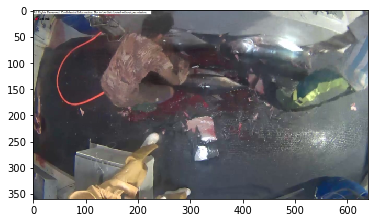

In [394]:
plt.imshow(to_plot(val_data_resize[img_num]))

In [395]:
cm = get_cm2(inp, 0)

In [396]:
#cm = get_cm2(inp, 4)

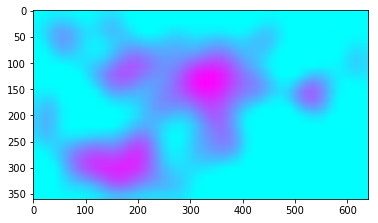

In [397]:
plt.imshow(cm, cmap="cool")

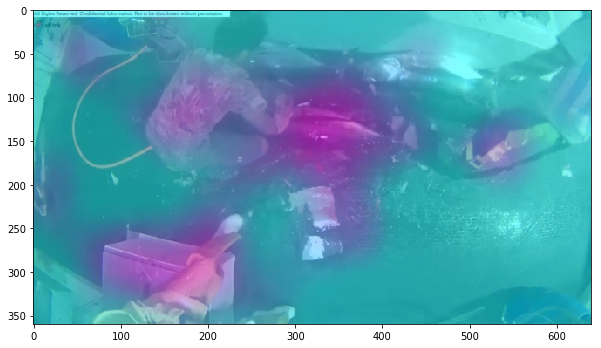

In [398]:
plt.figure(figsize=(10,10))
plot(val_data_resize[img_num])
plt.imshow(cm, cmap="cool", alpha=0.5)

### Inception mini-net

Here's an example of how to create and use "inception blocks" - as you see, they use multiple different convolution filter sizes and concatenate the results together. We'll talk more about these next year.

In [47]:
from keras.layers import AveragePooling2D

In [48]:
def conv2d_bn(x, filters, rows, cols, strides=(1,1)):
    x = Conv2D(filters, (rows, cols), strides=strides,
              activation='relu', padding='same')(x)
    return BatchNormalization(axis=1)(x)

In [49]:
def incep_block(x):
    branch1x1 = conv2d_bn(x, 32, 1, 1, strides=(2,2))
    
    branch5x5 = conv2d_bn(x, 24, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 32, 5, 5, strides=(2,2))
    
    branch3x3dbl = conv2d_bn(x, 24, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 48, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 48, 3, 3, strides=(2,2))
    
    branch_pool = AveragePooling2D((3,3), strides=(2,2), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 16, 1, 1)
    return Concatenate(axis=1)([branch1x1, branch5x5, branch3x3dbl, branch_pool])

In [52]:
inp = Input(vgg640.model.layers[-1].output_shape[1:])
x = BatchNormalization(axis=1)(inp)
x = incep_block(x)
x = incep_block(x)
x = incep_block(x)
x = Dropout(0.75)(x)
x = Conv2D(8, (3,3), padding='same')(x)
x = GlobalAveragePooling2D()(x)
outp = Activation('softmax')(x)

In [54]:
incep_model = Model(inp, outp)

In [55]:
incep_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [59]:
incep_model.fit(conv_features_640, trn_labels, epochs=2, verbose=2, 
               validation_data=(conv_val_features_640, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/2
 - 42s - loss: 1.1734 - acc: 0.6018 - val_loss: 1.2433 - val_acc: 0.6880
Epoch 2/2
 - 21s - loss: 0.3784 - acc: 0.8981 - val_loss: 0.3995 - val_acc: 0.8820


In [60]:
incep_model.fit(conv_features_640, trn_labels, epochs=2, verbose=2, 
               validation_data=(conv_val_features_640, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/2
 - 20s - loss: 0.1415 - acc: 0.9612 - val_loss: 0.2667 - val_acc: 0.9160
Epoch 2/2
 - 20s - loss: 0.0674 - acc: 0.9832 - val_loss: 0.2666 - val_acc: 0.9400


In [61]:
incep_model.lr = 1e-5

In [62]:
incep_model.fit(conv_features_640, trn_labels, epochs=6, verbose=2, 
               validation_data=(conv_val_features_640, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/6
 - 21s - loss: 0.0347 - acc: 0.9918 - val_loss: 0.2271 - val_acc: 0.9400
Epoch 2/6
 - 21s - loss: 0.0225 - acc: 0.9957 - val_loss: 0.2438 - val_acc: 0.9440
Epoch 3/6
 - 21s - loss: 0.0218 - acc: 0.9951 - val_loss: 0.2393 - val_acc: 0.9500
Epoch 4/6
 - 20s - loss: 0.0339 - acc: 0.9902 - val_loss: 0.2646 - val_acc: 0.9560
Epoch 5/6
 - 20s - loss: 0.0481 - acc: 0.9863 - val_loss: 0.2960 - val_acc: 0.9400
Epoch 6/6
 - 20s - loss: 0.0709 - acc: 0.9762 - val_loss: 0.2682 - val_acc: 0.9460


In [63]:
incep_model.fit(conv_features_640, trn_labels, epochs=10, verbose=2, 
               validation_data=(conv_val_features_640, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/10
 - 21s - loss: 0.0698 - acc: 0.9777 - val_loss: 0.2799 - val_acc: 0.9500
Epoch 2/10
 - 20s - loss: 0.0260 - acc: 0.9933 - val_loss: 0.2020 - val_acc: 0.9660
Epoch 3/10
 - 20s - loss: 0.0178 - acc: 0.9954 - val_loss: 0.2476 - val_acc: 0.9640
Epoch 4/10
 - 20s - loss: 0.0100 - acc: 0.9973 - val_loss: 0.2082 - val_acc: 0.9660
Epoch 5/10
 - 19s - loss: 0.0051 - acc: 0.9991 - val_loss: 0.2084 - val_acc: 0.9660
Epoch 6/10
 - 20s - loss: 0.0049 - acc: 0.9982 - val_loss: 0.1999 - val_acc: 0.9640
Epoch 7/10
 - 20s - loss: 0.0102 - acc: 0.9979 - val_loss: 0.2307 - val_acc: 0.9580
Epoch 8/10
 - 20s - loss: 0.0128 - acc: 0.9957 - val_loss: 0.2549 - val_acc: 0.9540
Epoch 9/10
 - 19s - loss: 0.0379 - acc: 0.9915 - val_loss: 0.2948 - val_acc: 0.9600
Epoch 10/10
 - 20s - loss: 0.0468 - acc: 0.9826 - val_loss: 0.2763 - val_acc: 0.9360


In [64]:
incep_model.save_weights(model_path+'incep_nmp.h5')

In [65]:
incep_model.load_weights(model_path+'incep_nmp.h5')

## Pseudo-labeling

In [144]:
class MixIterator(object):
    
    def __init__(self, iters):
        self.iters = iters
        self.n = int(np.sum([itr.n for itr in self.iters]))
        self.batch_size = int(np.sum([itr.batch_size for itr in self.iters]))
        self.steps_per_epoch = max([ceil(itr.n/itr.batch_size) for itr in self.iters])
    
    def reset(self):
        for itr in self.iters: itr.reset()
    
    def __iter__(self):
        return self
    
    def __next__(self, *args, **kwargs):
        nexts = [next(itr) for itr in self.iters]
        n0 = np.concatenate([n[0] for n in nexts])
        n1 = np.concatenate([n[1] for n in nexts])
        return (n0, n1)


In [138]:
preds = model.predict([conv_test_features, test_sizes_oh_norm], batch_size=batch_size*2)

In [139]:
gen = image.ImageDataGenerator()

In [140]:
test_batches = gen.flow(conv_test_features, preds, batch_size=16)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/preprocessing/image.py:855: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_first" (channels on axis 1), i.e. expected either 1, 3 or 4 channels on axis 1. However, it was passed an array with shape (1000, 512, 14, 14) (512 channels).
  ' (' + str(self.x.shape[channels_axis]) + ' channels).')


In [141]:
val_batches = gen.flow(conv_val_features, val_labels, batch_size=4)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/preprocessing/image.py:855: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_first" (channels on axis 1), i.e. expected either 1, 3 or 4 channels on axis 1. However, it was passed an array with shape (500, 512, 14, 14) (512 channels).
  ' (' + str(self.x.shape[channels_axis]) + ' channels).')


In [142]:
batches = gen.flow(conv_features, trn_labels, batch_size=44)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/preprocessing/image.py:855: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_first" (channels on axis 1), i.e. expected either 1, 3 or 4 channels on axis 1. However, it was passed an array with shape (3277, 512, 14, 14) (512 channels).
  ' (' + str(self.x.shape[channels_axis]) + ' channels).')


In [145]:
mi = MixIterator([batches, val_batches, test_batches])

In [147]:
bn_model.fit_generator(mi, epochs=2, verbose=2, 
                       steps_per_epoch=mi.steps_per_epoch,
                       validation_data=(conv_val_features, val_labels))

Epoch 1/2
 - 4s - loss: 0.1433 - acc: 0.9708 - val_loss: 0.0277 - val_acc: 0.9920
Epoch 2/2
 - 4s - loss: 0.0803 - acc: 0.9871 - val_loss: 0.0063 - val_acc: 1.0000


In [148]:
bn_model.fit_generator(mi, epochs=6, verbose=2, 
                       steps_per_epoch=mi.steps_per_epoch,
                       validation_data=(conv_val_features, val_labels))

Epoch 1/6
 - 4s - loss: 0.0732 - acc: 0.9884 - val_loss: 0.0057 - val_acc: 1.0000
Epoch 2/6
 - 4s - loss: 0.0672 - acc: 0.9906 - val_loss: 0.0040 - val_acc: 1.0000
Epoch 3/6
 - 4s - loss: 0.0661 - acc: 0.9896 - val_loss: 0.0030 - val_acc: 1.0000
Epoch 4/6
 - 4s - loss: 0.0640 - acc: 0.9926 - val_loss: 0.0074 - val_acc: 0.9980
Epoch 5/6
 - 4s - loss: 0.0646 - acc: 0.9898 - val_loss: 0.0050 - val_acc: 0.9980
Epoch 6/6
 - 4s - loss: 0.0630 - acc: 0.9917 - val_loss: 0.0029 - val_acc: 1.0000
